# PAIRS TRADING: Cointegration & Kalman Filter 

In [ ]:
!pip install yfinance

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import random 

sns.set()

### Get Exchange companies tickers

In [4]:
ibex = ['MAP.MC','ACS.MC','FER.MC','ACX.MC','GRF.MC','REE.MC','BBVA.MC','SAB.MC','BKT.MC','SGRE.MC','AMS.MC','FDR.MC','SAN.MC','TEF.MC','ENG.MC','PHM.MC','IBE.MC',
           'CABK.MC','MTS.MC','VIS.MC','NTGY.MC','ELE.MC','CLNX.MC','ANA.MC','MEL.MC','COL.MC','MRL.MC','ITX.MC','IAG.MC','AENA.MC']

cac = ['VIV.PA','WLN.PA','DG.PA','AI.PA','EN.PA','SW.PA','ENGI.PA','ATO.PA','ORA.PA','SAN.PA','MC.PA','AC.PA','SGO.PA','CA.PA','GLE.PA','ACA.PA','BN.PA','KER.PA',
       'HO.PA','AIR.PA','BNP.PA','ML.PA','SU.PA','RI.PA','CAP.PA','VIE.PA','UG.PA','FP.PA','OR.PA','LR.PA']

europe = ['RED.MC','ENG.MC','MAP.MC','ACS.MC','FER.MC','ACX.MC','GRF.MC','REE.MC','BBVA.MC','SAB.MC','BKT.MC','SGRE.MC','AMS.MC','FDR.MC','SAN.MC','TEF.MC','ENG.MC','PHM.MC','IBE.MC',
           'CABK.MC','MTS.MC','VIS.MC','NTGY.MC','ELE.MC','CLNX.MC','ANA.MC','MEL.MC','COL.MC','MRL.MC','ITX.MC','IAG.MC','AENA.MC','VIV.PA','WLN.PA','DG.PA','AI.PA',
           'EN.PA','SW.PA','ENGI.PA','ATO.PA','ORA.PA','SAN.PA','MC.PA','AC.PA','SGO.PA','CA.PA','GLE.PA','ACA.PA','BN.PA','KER.PA',
           'HO.PA','AIR.PA','BNP.PA','ML.PA','SU.PA','RI.PA','CAP.PA','VIE.PA','UG.PA','FP.PA','OR.PA','LR.PA','GBLB.BR','EDEN.PA','KBC.BR','ABI.BR','RAND.AS','SAN.PA',
          'AC.PA','FDJ.PA','AGN.AS','MC.PA','INGA.AS','STLA.PA','PHIA.AS','UBI.PA','RDSA.AS','TEP.PA','ASML.AS','AGS.BR','EDPR.LS','LR.PA','GALP.LS','JMT.LS','ASM.AS',
          'EDF.PA','ORA.PA','SAB.MC','VIS.MC','AF.PA','NOKIA.PA','VIV.PA','SEV.PA','ACA.PA','CS.PA','TFI.PA','SAN.PA','ACX.MC','ACS.MC','MAP.MC','IDR.MC','EBRO.MC']

forex = ['EURUSD=X','JPY=X','GBPUSD=X','AUDUSD=X','NZDUSD=X','EURJPY=X','GBPJPY=X','EURGBP=X','EURCAD=X']

### Download Price Data

In [6]:
raw_data = yf.download(europe, period='ytd') # ytd ,2y, 5y, 10y
raw_data.to_csv('priceExchange_YTD.csv')

[*********************100%***********************]  88 of 88 completed

5 Failed downloads:
- SEV.PA: No data found, symbol may be delisted
- UG.PA: No data found, symbol may be delisted
- RDSA.AS: No data found, symbol may be delisted
- FP.PA: No data found, symbol may be delisted
- REE.MC: No data found, symbol may be delisted


## START DATA PROCESSING ---raw_data

#### Adjusted price Data only


In [7]:
# get only adj close price  column for each downloaded price inf stock
data = raw_data.copy()
data = data['Adj Close']
data = data.iloc[0:-1,:]
data.shape

(223, 88)

#### Delete columns with na values

In [8]:
data = data.dropna(axis=1)
data = data.dropna()  # axis 0
data.shape

(223, 83)

### Split data to avoid look ahead bias in the correlation, cointegration and adfuller tests

In [9]:
data_test = data.iloc[0:int(len(data)*0.4),:]
data_test.shape

(89, 83)

#### CORRELATION of stocks

In [10]:
alpha = 0.05 # minimal significance value to take into acount to filter test results (cointegration and adfuller)
alpha_2 = 0.05
corr_coef = 0.90 # correlation coef taken as threshold

In [11]:
corr = data_test.corr().unstack() # Agrupamos cada valor columna con el valor fila

In [12]:
# all correlation values stored in a dataframe 
df_corr = pd.DataFrame(corr,columns=["Correlation"])
df_corr['absCorrelation'] = np.abs(df_corr['Correlation'])
df_corr.head()

Correlation  absCorrelation
ABI.BR ABI.BR     1.000000        1.000000
       AC.PA      0.688330        0.688330
       ACA.PA     0.610708        0.610708
       ACS.MC     0.171157        0.171157
       ACX.MC     0.617901        0.617901

#### Filtering Hight correlated stocks

In [14]:
# filtering high correlated stock threshold  and less than 1,
# we use abs of the correlation factor to perform the value filter
correlated = df_corr[(df_corr['absCorrelation']>corr_coef) & (df_corr['absCorrelation'] != 1.0)]
correlated.head()

Correlation  absCorrelation
AC.PA  DG.PA       0.936586        0.936586
       ENGI.PA     0.922501        0.922501
ACA.PA ACX.MC      0.921183        0.921183
       BNP.PA      0.986984        0.986984
       GLE.PA      0.994177        0.994177

In [15]:
l_corr_pairs = (correlated.index).values.tolist()
s1 = []
s2 = []
for p in l_corr_pairs:
    s1.append(p[0])
    s2.append(p[1])  

In [17]:
corr_pairs = pd.DataFrame()
corr_pairs['Stock1'] = s1
corr_pairs['Stock2'] = s2
corr_pairs['Correlation'] = correlated['Correlation'].values

# delete duplicates  meaning : (ACN - RSG  and RSG - ACN)
corr_pairs = corr_pairs[pd.DataFrame(np.sort(corr_pairs[['Stock1','Stock2']].values,1)).duplicated()]
corr_pairs = corr_pairs.reset_index(drop=True)

print(corr_pairs.shape)
corr_pairs.head()

(92, 3)


,Stock1,Stock2,Correlation
0,ACX.MC,ACA.PA,0.921183
1,ASML.AS,ASM.AS,0.913847
2,BNP.PA,ACA.PA,0.986984
3,BNP.PA,ACX.MC,0.908029
4,DG.PA,AC.PA,0.936586


### Let's find if the pairs are cointegrated and check for multicolLinearity (VIF)

    Ho: Null hypothesis is that there is no cointegration
    H1: Alternative hypothesis is that there is cointegrating relationship
    
    If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship
    p_value treshold is 𝜶 = 0.05 
    
    so we look for the following condirion to reject the null hypothesis:
    
                p_value < 𝜶      (𝜶 = 0.05)
                
     https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html
     
     
    
    COLLINEARITY CHECK
    #from statsmodels.stats.outliers_influence import variance_inflation_factor

    #variables = data[[stock1,stock2]]
    #vif = pd.DataFrame()
    #vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
    #vif['Features'] = variables.columns

In [18]:
import statsmodels.tsa.stattools as ts
from statsmodels.stats.outliers_influence import variance_inflation_factor

p_value_coint = []
for row in corr_pairs.iterrows():
    stock1 = row[1][0]
    stock2 = row[1][1]
    pval_coint_iter = ts.coint(data_test[stock1],data_test[stock2]) 
    p_value_coint.append(pval_coint_iter[1])


corr_coint_pairs = corr_pairs.copy()
corr_coint_pairs['coint p_val'] = p_value_coint

# filte pairs with cointegration test p_value < 0.05
corr_coint_pairs = corr_coint_pairs[corr_coint_pairs['coint p_val']<alpha]
corr_coint_pairs = corr_coint_pairs.reset_index(drop=True)
corr_coint_pairs

,Stock1,Stock2,Correlation,coint p_val
0,DG.PA,AC.PA,0.936586,0.003038
1,ENGI.PA,AC.PA,0.922501,0.012847
2,GLE.PA,BBVA.MC,0.914280,0.038439
3,HO.PA,ATO.PA,-0.930428,0.013294
4,IAG.MC,BBVA.MC,0.925637,0.026363
5,IAG.MC,GLE.PA,0.920453,0.038882
6,INGA.AS,GLE.PA,0.989218,0.022755
7,ITX.MC,ACX.MC,0.908194,0.003251
8,ITX.MC,GALP.LS,-0.901857,0.042309
9,LR.PA,FDR.MC,0.963869,0.007114


### Augmented Dickey-Fuller

A time series is said to be “stationary” if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time.

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

    H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

    HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary

https://www.statology.org/dickey-fuller-test-python/

In [19]:
p_value_adfuller = []
for row in corr_coint_pairs.iterrows():
    stock1 = row[1][0]
    stock2 = row[1][1]
    x = data_test[stock1]
    y = data_test[stock2]
    pval_adful_iter = ts.adfuller(x-y)
    p_value_adfuller.append(pval_adful_iter[1]) # stores the p_value of the test
p_value_adfuller

corr_coint_adful_pairs = corr_coint_pairs.copy()
corr_coint_adful_pairs['p_value adfuller'] = p_value_adfuller
corr_coint_adful_pairs
#if smaller than 0.05 , the time siries is stationary
# filtering p_val of adfuller smaller than 0.05
corr_coint_adful_pairs = corr_coint_adful_pairs[corr_coint_adful_pairs['p_value adfuller']<alpha_2]
corr_coint_adful_pairs = corr_coint_adful_pairs.reset_index(drop=True)
print(corr_coint_adful_pairs.shape)
corr_coint_adful_pairs

(5, 5)


,Stock1,Stock2,Correlation,coint p_val,p_value adfuller
0,STLA.PA,ACA.PA,0.934126,0.011112,0.002076
1,STLA.PA,INGA.AS,0.929750,0.010148,0.005692
2,SW.PA,BNP.PA,0.944322,0.000859,0.000548
3,SW.PA,GLE.PA,0.950013,0.002289,0.003368
4,VIE.PA,INGA.AS,0.933021,0.013664,0.014821


## Kalman Filtering 

#### Compute whith past values the regression values

LS  regression to find initial Beta_0 and Beta_1

stock1(t) = bo + b1*stock2(t)


In [20]:
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 26.2 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=2849bbc82ef636b683f0599a3042ff64489c542be2e572447d06a9e1aa80652e
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [21]:
from pykalman import KalmanFilter
def KalmanFilterAverage(price_data):
    # construction of the Kalman filter
    kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance = 1,
    transition_covariance=0.01)
    
    # use of observed values of the price to get a rolling mean 
    state_means, state_covariance  = kf.filter(price_data.values)
    state_means = pd.Series(state_means.flatten(), index=price_data.index)
    return state_means

In [22]:
def KalmanFilterRegression(x,y):
    """
    Returns array of the state means bector Beta1 slope of the regression and Beta0 intercept 
    form : [beta1,beta0]
    """
    # x: independent variable of the observation equation (stock2)
    # y: dependent variable of the observation equation (stock1)
    # spread =  y - beta*x 
    # observation eq: y = (Beta0, Beta1)*(1,xt) + vt
    delta = 0.001
    trans_cov = (delta/(1-delta))*np.eye(2)
    obs_matrix = np.expand_dims(np.vstack([[x],[np.ones(len(x))]]).T,axis=1) #  row (1, stock2) si  y = (Beta_0,Beta_1)*(1,x).T + vt
    
    kf = KalmanFilter(
        n_dim_obs = 1, # y
        n_dim_state = 2, # Beta0 and Beta1 
        initial_state_mean = [0,0],
        initial_state_covariance = np.ones((2,2)),
        transition_matrices = np.eye(2),
        observation_matrices = obs_matrix,
        observation_covariance = 2,
        transition_covariance = trans_cov)
    
    state_means , state_covs = kf.filter(y.values)
    return state_means

In [23]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    lamb = np.float64(res.params[1])
    halflife = int((np.log(2)*(-1))/lamb)
    
    if halflife <= 0.0:
        halflife = 1.0
    return halflife

In [24]:
print(corr_coint_adful_pairs.shape)
corr_coint_adful_pairs.head()

(5, 5)


,Stock1,Stock2,Correlation,coint p_val,p_value adfuller
0,STLA.PA,ACA.PA,0.934126,0.011112,0.002076
1,STLA.PA,INGA.AS,0.929750,0.010148,0.005692
2,SW.PA,BNP.PA,0.944322,0.000859,0.000548
3,SW.PA,GLE.PA,0.950013,0.002289,0.003368
4,VIE.PA,INGA.AS,0.933021,0.013664,0.014821


HalfLife of the spread is 8 days
spread = INGA.AS + VIE.PA*-0.4365214457397472
Actual Zt spread value: 0.7263989863570864


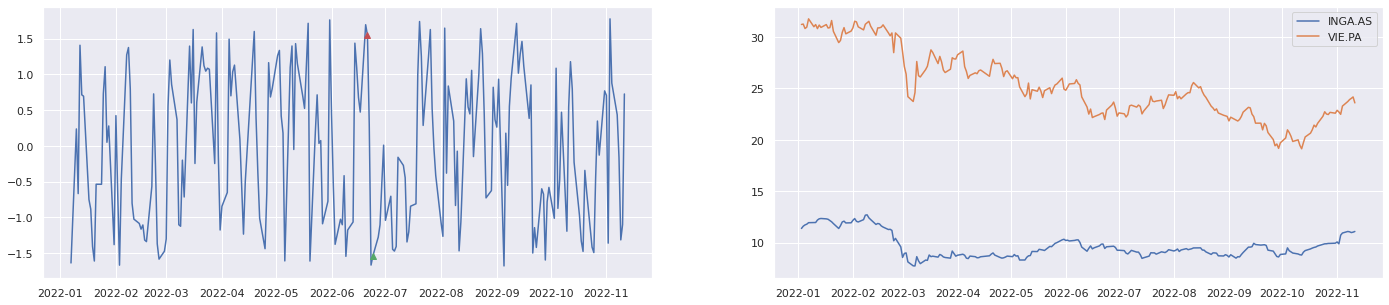

In [90]:
n = random.choices(range(len(corr_coint_adful_pairs)),k=1)[0] # random pick row from corr_coint_adful_pairs
# n = 0 # use hardcoded value if want to directly pick row to inspect

x = data[corr_coint_adful_pairs.iloc[n,0]] # get price data stock x or stock 1
y = data[corr_coint_adful_pairs.iloc[n,1]] # get price data stock y or stock 2
df = pd.DataFrame()
df['y'] = y
df['x'] = x
# apply kalman filter regression to find the time-variable hedge ratio
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y)) 

df['hedgeRatio'] = - state_means[:,0]
df['spread'] = df.y + (df.x*df.hedgeRatio)
halflife = half_life(df['spread'])
print('HalfLife of the spread is {} days'.format(halflife))
# calculate the z-score with window = half life period
meanSpread = df.spread.rolling(window=5).mean()
stdSpread = df.spread.rolling(window=5).std()
df['z-score'] = (df.spread - meanSpread)/stdSpread
print('spread = {} + {}*{}'.format(y.name,x.name,df.hedgeRatio[-1]))
print('Actual Zt spread value: {}'.format(df['z-score'][-1]))
# Trade Logic
sell = []
buy = []
sell.append(np.nan)
buy.append(np.nan)
for t in np.arange(1,len(df)):
    if df['z-score'][t-1] > 1.5 and df['z-score'][t] > 1.5:
        sell.append(df['z-score'][t])
    else:
        sell.append(np.nan)
    if df['z-score'][t-1] < -1.5 and df['z-score'][t]< -1.5:
        buy.append(df['z-score'][t])
    else:
        buy.append(np.nan)
df['Buy'] =  buy
df['Sell'] = sell
# PLOT
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(24,5))
ax[0].plot(df['z-score'])
ax[0].plot(df['Buy'], color='g',linestyle='None',marker='^',label='Buy')
ax[0].plot(df['Sell'], color='r',linestyle='None',marker='^',label='Sell')
ax[1].plot(df[['y']],label = (y.name))
ax[1].plot(df[['x']],label = (x.name))
plt.legend()
plt.show()

### Meaning of the trade signal:

    spread = y - x*hedgeRatio


    SELL) if spread increases by positive side (+), means stock1 is going higher than stock2 so in order to mean revert:

            Short -> y
            Long ->  x


    BUY) if spread increase by the negative side(-), means stock1 is going lower than stock2 so in order to mean revert:

            Long -> y
            Short -> x





   ##### Kalman filter resources and other interesiting info

https://medium.com/analytics-vidhya/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968

https://medium.com/analytics-vidhya/understanding-and-implementing-kalman-filter-in-python-for-pairs-trading-9b8986d79b2d

https://www.kalmanfilter.net/default.aspx

https://pykalman.github.io/

https://www.youtube.com/watch?v=yyvIcdYkb9o&t=1839s